# 7. Introduction to algorithms aggregation

In this notebook, I will introduce our work on **improving algorithms aggregation techniques** using embedded voting.

In [1]:
import numpy as np
import embedded_voting as ev
import matplotlib.pyplot as plt
np.random.seed(42)

Let's assume we have a set of algorithms $\mathcal A = \{A_1, \ldots, A_n \}$ and a set of inputs $\mathcal X$.

Each algorithm is a function from $\mathcal X$ to $\mathbb R$. In other word, each algorithm is a function that assigns a score to every input.

For a decision problem, we have a set of candidate $\mathcal C \subseteq \mathcal X$ and we want to select the best one, **using the scores** given by the different algorithms.

In this notebook, we assume that each $x \in \mathcal X$ is associated to a ground truth score $s(x)$, and each algorithm return a **noisy** version of the score.

## Simulate the algorithms with random models

The first thing we want to do is **simulate the decision algorithms**. 

We can use for that a scores generator. For instance, the class *<tt>GroupedMeanGenerator</tt>* create different groups of algorithm $(G_1, \ldots, G_k)$ and take as parameters *the number of algorithm in each group*, the *group noise variance $\sigma_g$* and the *independent noise variance $\sigma_i$*.

Let's take some input $x \in \mathcal X$ with score $s(x)$.

Then, for each group of algorithm $G_j$, we draw a **group noise** $\epsilon(G_j) \sim \mathcal N(0, \sigma_g)$, and for each algorithm $A_i$, we draw an **independent noise** $\epsilon(A_i) \sim \mathcal N(0, \sigma_i)$. 

The score given by $A_i \in G_j$ to $x$ will be 

$$
s_{A_i}(x) = s(x) +  \epsilon(G_j) + \epsilon(A_i)
$$

In the following cell, we create an instance of such generator and plot an example of the scores drawn for one candidate. Each color represents a group and you can clearly distinguish the **different groups**.

### Examples of generator

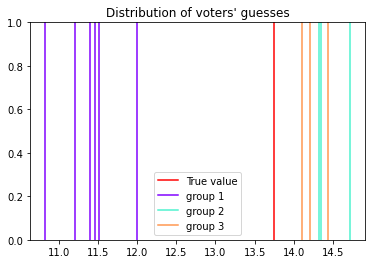

In [2]:
ev.GroupedMeanGenerator([6, 3, 3], 5, 0.25).plot_scores()

We proposes **other classes of generators**, and you can build your own.

For instance :
   
   * **<tt>GroupedMixGenerator</tt>** : Each group $G_j$ is associated with a feature vector $f_j$ of length $d$. We then draw $d$ different "*group noise*" $\forall k \le d, \epsilon_g(k) \sim \mathcal N(0, \sigma_g)$, and independent noise $\epsilon(A_i)$ for each candidate as before. But now the score given by the algorithm $A_i \in G_j$ is :
   
   $$
   s_{A_i}(x) = s(x) + \dfrac{\sum_{k=1}^d f_j(k) \times \epsilon_g(k)}{\sum_{k=1}^d f_j(k) } + \epsilon(A_i)
   $$
   
   In that way, different groups can be correlated.
   
   * **<tt>GroupedNoiseGenerator</tt>** : For each group, we draw a variance $\sigma(G_j) \sim \mathcal N(0,\sigma_g)$ and for each algorithm $A_i \in G_j$, the noise is drawn according to the law $\mathcal N(0, \sigma(G_j))$. In other word, algorithms from the same group share the same noise.
   
   * **<tt>MultivariateGenerator</tt>** : This directly takes as input a covariance matrix $M$ and an independent noise variance $\sigma_i$, and draw scores using **a multivariate normal law** based on $M$.

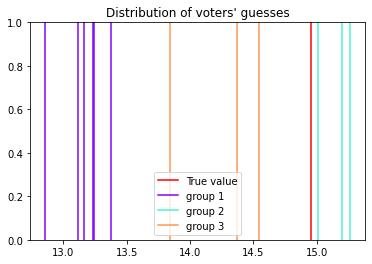

In [3]:
ev.GroupedMixGenerator([6, 3, 3], [[1, 0], [0, 1], [.5, .5]], 5, .25).plot_scores()

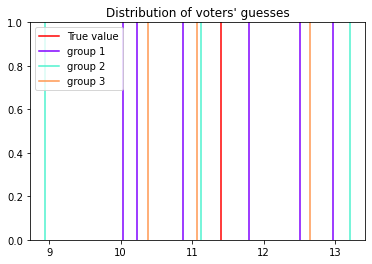

In [4]:
ev.GroupedNoiseGenerator([6, 3, 3], 3).plot_scores()

### Samples scores

With your generator, you can sample scores using the **sample_scores** function, which return the true values of the candidates input $x \in \mathcal X$, and the scores given by the different algorithms.

In [5]:
generator = ev.GroupedMeanGenerator([10, 4, 1])
generator.set_group_noise(5)
generator.set_independent_noise(0.25)
n_candidates = 20
true_values, scores = generator.sample_scores(n_candidates)

I can put the true values in a **fake voting profile** with one voter to get the *scores*, the *ranking* and the *welfare* of every candidate in this decision problem:

In [6]:
ground_truth = ev.Profile(n_candidates, 0)
ground_truth.add_voter([], true_values)

target = ev.SumScores(ground_truth)
print("Target scores : ",target.scores_)
print("Target ranking : ",target.ranking_)
print("Target welfare : ",target.welfare_)
print("Target winner : ",target.winner_)
welfare = target.welfare_

Target scores :  [17.13244787222995, 11.198653673336828, 10.165878289278561, 13.253996981592678, 19.900538501042632, 16.22890475819, 10.453040097720445, 17.506147516408582, 18.218600592903563, 15.843143119231001, 11.29159415151495, 14.591357562382612, 17.474709381337565, 11.733735952947548, 14.118409141472686, 11.168980407083641, 16.11454235434648, 19.148459010681, 12.219721619329494, 17.636057941597606]
Target ranking :  [4, 17, 8, 19, 7, 12, 0, 5, 16, 9, 11, 14, 3, 18, 13, 10, 1, 15, 6, 2]
Target welfare :  [0.715645891217906, 0.10609259713145264, 0.0, 0.31722922270899706, 1.0, 0.6228287723473325, 0.02949890414201168, 0.7540344570280435, 0.8272217137988552, 0.5832011294129836, 0.11563997486794574, 0.45461055412658163, 0.7508049519002709, 0.16105931070652812, 0.4060265860556282, 0.10304438942746642, 0.6110808118273219, 0.9227420912490851, 0.21098253923325638, 0.7673795992685535]
Target winner :  4


## Scores inference

Now, let's assume we only have access to the *scores* and not the *true values* of the candidates. How can we aggregate the predictions of the different algorithms to find the **best candidate?**

### Trivial method

The trivial method consists in doing the **sum** or, in an equivalent way, the **average** of the scores.

We can simulate this with a profile with no embeddings (the number of dimensions is set to $0$):

In [7]:
algorithms = ev.Profile(n_candidates, 0)
algorithms.add_voters(np.zeros((15,0)), scores)

Unfortunately, in this example this method does not return the **best candidate**, but the second one.

It is partially due to the fact that there is a big group of algorithms with similar predictions. If all the group is wrong, then the average prediction will be bad because of the size of the group.

In [8]:
guess = ev.SumScores(algorithms)
print("Guessed ranking : ",guess.ranking_)
print("Guessed winner : ",guess.winner_)
print("Welfare reached : ",welfare[guess.winner_])

Guessed ranking :  [8, 4, 17, 0, 9, 19, 11, 16, 5, 7, 1, 14, 18, 3, 13, 2, 15, 12, 10, 6]
Guessed winner :  8
Welfare reached :  0.8272217137988552


### Using geometrical voting rules

Fortunately, to improve our results, we can use **our embedded voting model!**

For that, we need a bunch of training samples to detect the correlations between the different algorithms. In the following cell, we generate $100$ such samples.

Then, we create a profile with the class *<tt>AutoProfile</tt>*. When we use the function **add_voters_auto** with the *training samples* and candidates' *scores*. This function will automatically create **voters' embeddings** based on their correlations. 

In [9]:
_, train_samples = generator.sample_scores(100)
profile = ev.AutoProfile(n_candidates, 3).add_voters_auto(scores, train_samples)

If we plot the profile, we can see that there are $3$ different groups of voters, as expected.

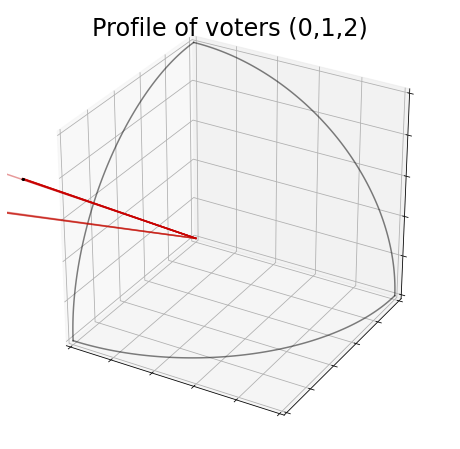

In [10]:
profile.plot_profile()

However, the plot is not really good because the voters vectors are not in the non-negative orthant, so we can use **recenter** to rotate the profile and obtain a better plot:

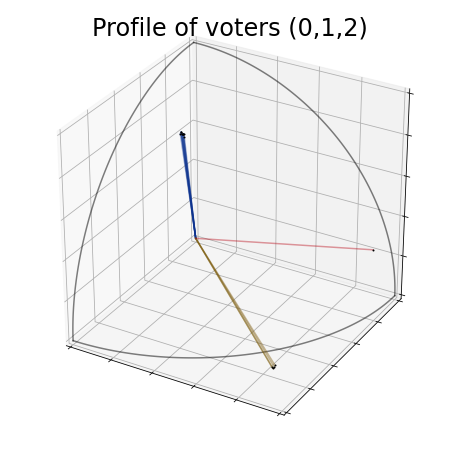

In [11]:
profile.recenter(approx=False).dilate().plot_profile()

Now that this is done, we can apply any of the rules I presented in the previous notebooks!

In this example, **SVDNash** and the **Zonotope Rule** find the **best candidate**.

In [12]:
guess_nash = ev.SVDNash(profile)
print("Guessed ranking : ",guess_nash.ranking_)
print("Guessed winner : ",guess_nash.winner_)
print("Welfare reached : ",welfare[guess_nash.winner_])

Guessed ranking :  [4, 17, 8, 19, 0, 16, 5, 9, 11, 7, 14, 3, 1, 18, 15, 13, 10, 2, 12, 6]
Guessed winner :  4
Welfare reached :  1.0


In [13]:
guess_zonotope = ev.ZonotopeRule(profile)
print("Guessed ranking : ",guess_zonotope.ranking_)
print("Guessed winner : ",guess_zonotope.winner_)
print("Welfare reached : ",welfare[guess_zonotope.winner_])

Guessed ranking :  [4, 17, 8, 19, 0, 16, 5, 9, 11, 7, 14, 3, 1, 18, 15, 13, 10, 2, 12, 6]
Guessed winner :  4
Welfare reached :  1.0


In [14]:
guess_features = ev.FeaturesRule(profile)
print("Guessed ranking : ",guess_features.ranking_)
print("Guessed winner : ",guess_features.winner_)
print("Welfare reached : ",welfare[guess_features.winner_])

Guessed ranking :  [8, 4, 17, 19, 0, 12, 5, 11, 9, 16, 7, 3, 14, 1, 18, 15, 10, 13, 2, 6]
Guessed winner :  8
Welfare reached :  0.8272217137988552


### Using maximum likelihood

Another natural method to aggregate the different score is to assume scores are drawn from a **multivariate normal law** and use the *maximum likelihood estimator*. For that, we need to infer the covariance matrix between the algorithms.

Fortunately, that's exactly what the function **add_voters_cov** is doing, using the *training samples* and the *candidates' scores*.

In [15]:
profile_MLE = ev.AutoProfile(n_candidates, 15).add_voters_cov(scores, train_samples)

In this particular example, **MLE** does not improve the result, but it can be due to the size of the training set.

In [16]:
guess_mle = ev.MLERule(profile_MLE)
print("Guessed ranking : ",guess_mle.ranking_)
print("Guessed winner : ",guess_mle.winner_)
print("Welfare reached : ",welfare[guess_mle.winner_])

Guessed ranking :  [8, 17, 4, 0, 19, 14, 7, 16, 9, 5, 1, 11, 18, 13, 2, 3, 12, 10, 15, 6]
Guessed winner :  8
Welfare reached :  0.8272217137988552


### With more training

We can legitimately ask ourselves what happen if you have more training samples, let's say $1000$ for instances:

In [17]:
_, train_samples = generator.sample_scores(1000)
profile = ev.AutoProfile(n_candidates, 3).add_voters_auto(scores, train_samples)
profile_MLE = ev.AutoProfile(n_candidates, 15).add_voters_cov(scores, train_samples)

As you can see in the following cells, almost every method using the training set now returns the **best candidate**.

In [18]:
guess_nash = ev.SVDNash(profile)
print("Guessed winner (SVDNash) : ",guess_nash.winner_)
print("Welfare reached (SVDNash) : ",welfare[guess_nash.winner_])
guess_zonotope = ev.ZonotopeRule(profile)
print("Guessed winner (ZonotopeRule) : ",guess_zonotope.winner_)
print("Welfare reached (ZonotopeRule) : ",welfare[guess_zonotope.winner_])
guess_features = ev.FeaturesRule(profile)
print("Guessed winner (FeaturesRule) : ",guess_features.winner_)
print("Welfare reached (FeaturesRule) : ",welfare[guess_features.winner_])

guess_mle = ev.MLERule(profile_MLE)
print("Guessed winner (MLE) : ",guess_mle.winner_)
print("Welfare reached (MLE): ",welfare[guess_mle.winner_])


Guessed winner (SVDNash) :  4
Welfare reached (SVDNash) :  1.0
Guessed winner (ZonotopeRule) :  4
Welfare reached (ZonotopeRule) :  1.0
Guessed winner (FeaturesRule) :  12
Welfare reached (FeaturesRule) :  0.7508049519002709
Guessed winner (MLE) :  4
Welfare reached (MLE):  1.0


However, this notebook only shows one particular example. In the next notebook, we are doing a deeper analysis of algorithm aggregation.

## Bonus : PCA with full rank is equivalent to Cov

In [20]:

true_values, scores = generator.sample_scores(n_candidates)
_, train_samples = generator.sample_scores(100)
profile_fullpca = ev.AutoProfile(n_candidates, 3).add_voters_auto(scores, train_samples, generator.n_voters)
profile_cov = ev.AutoProfile(n_candidates, 3).add_voters_cov(scores,train_samples)

In [21]:
profile_cov.embeddings

array([[12.76123533, 12.7786582 , 12.86456527, 12.76482105, 12.69398074,
        12.79881125, 12.78629853, 12.70474215, 12.77171706, 12.84859625,
         8.25974772,  8.1240581 ,  8.24260303,  8.44313639,  8.14114406],
       [12.7786582 , 12.92062202, 12.93778759, 12.84342533, 12.77048727,
        12.86925739, 12.87606091, 12.78312882, 12.8473528 , 12.92568739,
         8.1825301 ,  8.0556078 ,  8.17107783,  8.37886304,  8.17748972],
       [12.86456527, 12.93778759, 13.09625698, 12.93951159, 12.85629644,
        12.96168662, 12.94962839, 12.86010516, 12.94161229, 13.02583487,
         8.25316303,  8.11145903,  8.24799623,  8.45397567,  8.21317935],
       [12.76482105, 12.84342533, 12.93951159, 12.89382243, 12.75448728,
        12.85944935, 12.86239689, 12.77196034, 12.84317931, 12.93036117,
         8.26122649,  8.12753528,  8.23325171,  8.44811694,  8.08031455],
       [12.69398074, 12.77048727, 12.85629644, 12.75448728, 12.73068265,
        12.7827154 , 12.77450357, 12.68662367, 

In [22]:
profile_fullpca.embeddings

array([[-9.97034292e-01, -7.68988624e-02, -2.75147532e-03,
        -2.20958522e-04, -1.99654246e-04, -6.14224829e-04,
        -5.13023103e-04, -4.78874060e-04, -1.59530468e-04,
         5.96149488e-04, -7.98027984e-05,  3.26859217e-04,
         3.89406139e-04, -9.11796385e-05, -4.57509551e-05],
       [-9.96644298e-01, -8.18228592e-02, -1.80727477e-03,
        -9.36930871e-04,  4.66620454e-04,  1.08920471e-04,
         3.15568527e-04, -2.56198832e-04, -3.69829136e-04,
        -5.14132833e-04,  3.95132623e-05, -2.46993930e-04,
         2.37162536e-04, -3.11417907e-04, -8.94266717e-05],
       [-9.96680960e-01, -8.13598273e-02, -2.39946218e-03,
         9.85168378e-04, -4.38605712e-04,  2.88200883e-04,
         4.86646437e-04, -3.20552432e-04, -1.41350031e-04,
         4.68123285e-05, -4.91927069e-05,  8.72007507e-05,
        -1.88422599e-04, -4.51436793e-04,  1.69597691e-04],
       [-9.96856365e-01, -7.90865714e-02, -4.61812894e-03,
         3.67739218e-04,  5.23572036e-04,  2.62922488